In [5]:
!pip -q install imbalanced-learn shap lime dask[complete] dask-ml streamlit joblib

In [6]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, classification_report,
                             silhouette_score, adjusted_rand_score)
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif, RFECV, SelectFromModel

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import shap, lime
from lime.lime_tabular import LimeTabularExplainer

import joblib
np.random.seed(42)


csv_path = "heart.csv"
assert os.path.exists(csv_path), f"Could not find {csv_path} in working directory."
df_raw = pd.read_csv(csv_path)

In [7]:
print("Shape:", df_raw.shape)
print("\nHead:")
display(df_raw.head())
print("\nInfo:")
display(df_raw.info())
print("\nMissing values per column:")
display(df_raw.isna().sum())


expected_cols = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach',
                 'exang','oldpeak','slope','ca','thal','target']
missing = set(expected_cols) - set(df_raw.columns)
assert not missing, f"Missing expected columns: {missing}"


df = df_raw.drop_duplicates().copy()
print("After dropping duplicates:", df.shape)

Shape: (303, 14)

Head:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


None


Missing values per column:


,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


After dropping duplicates: (302, 14)


# Missing values handling (numeric + categorical)
Identify numeric vs categorical columns.

Some columns are numeric but represent categories

Convert categoricals to 'category' dtype

Simple missingness report

We'll impute within pipelines later, but here's a clean X/y split now

Keep a backup copy for certain analyses

In [8]:
categorical_like = ['cp','restecg','slope','ca','thal','sex','fbs','exang']
numeric_cols = [c for c in df.columns if c not in categorical_like + ['target']]
cat_cols = categorical_like


for c in cat_cols:
    df[c] = df[c].astype('category')


print("Missing before imputation:")
display(df[expected_cols].isna().sum())

X = df.drop(columns=['target'])
y = df['target'].astype(int)

X_base = X.copy()
y_base = y.copy()


Missing before imputation:


,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


# Outlier detection & treatment IQR capping

capping for numeric columns to reduce outlier influence

In [9]:
X_out = X_base.copy()
for col in numeric_cols:
    q1, q3 = X_out[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    X_out[col] = np.clip(X_out[col], lower, upper)

#check metrics
def summarize(col):
    return pd.Series({
        'min': col.min(),
        'q1': col.quantile(0.25),
        'median': col.median(),
        'q3': col.quantile(0.75),
        'max': col.max()
    })

print("Numeric summaries BEFORE capping:")
display(X_base[numeric_cols].apply(summarize))
print("\nNumeric summaries AFTER capping:")
display(X_out[numeric_cols].apply(summarize))

#capped version
X = X_out


Numeric summaries BEFORE capping:


,age,trestbps,chol,thalach,oldpeak
min,29.0,94.0,126.00,71.00,0.0
q1,48.0,120.0,211.00,133.25,0.0
median,55.5,130.0,240.50,152.50,0.8
q3,61.0,140.0,274.75,166.00,1.6
max,77.0,200.0,564.00,202.00,6.2



Numeric summaries AFTER capping:


,age,trestbps,chol,thalach,oldpeak
min,29.0,94.0,126.000,84.125,0.0
q1,48.0,120.0,211.000,133.250,0.0
median,55.5,130.0,240.500,152.500,0.8
q3,61.0,140.0,274.750,166.000,1.6
max,77.0,170.0,370.375,202.000,4.0


# Feature engineering

In [10]:
X_fe = X.copy()

X_fe['bp_chol_ratio'] = X_fe['trestbps'] / (X_fe['chol'] + 1e-6)
X_fe['age_oldpeak'] = X_fe['age'] * X_fe['oldpeak']
X_fe['age_bin'] = pd.cut(X_fe['age'], bins=[0,40,50,60,120], labels=[0,1,2,3]).astype('category')

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_feats = ['trestbps','chol','thalach','oldpeak']
poly_mat = poly.fit_transform(X_fe[poly_feats])
poly_cols = [f"{v}_p{ix}" for ix, v in enumerate(poly.get_feature_names_out(poly_feats))]
poly_df = pd.DataFrame(poly_mat, columns=poly_cols, index=X_fe.index)
X_fe = pd.concat([X_fe, poly_df], axis=1)

# Update columns
cat_cols_ext = cat_cols + ['age_bin']
num_cols_ext = [c for c in X_fe.columns if c not in cat_cols_ext]

print("Final engineered columns:", X_fe.shape[1])


Final engineered columns: 30


# Data visualization (distributions, correlations)

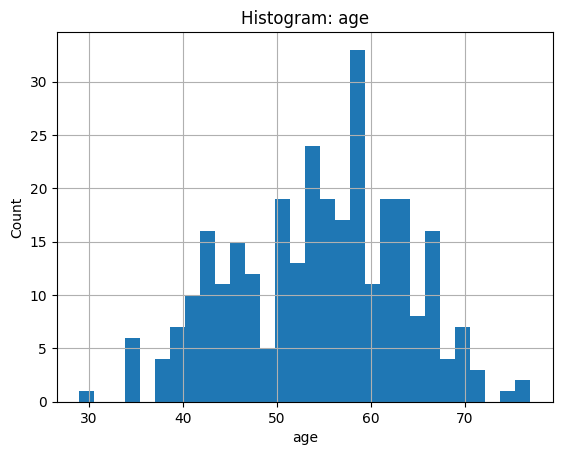

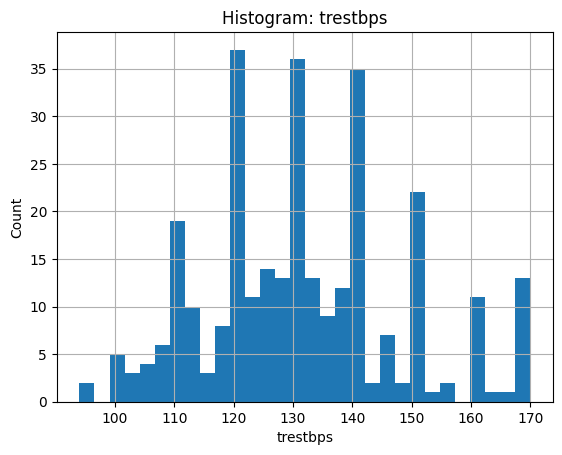

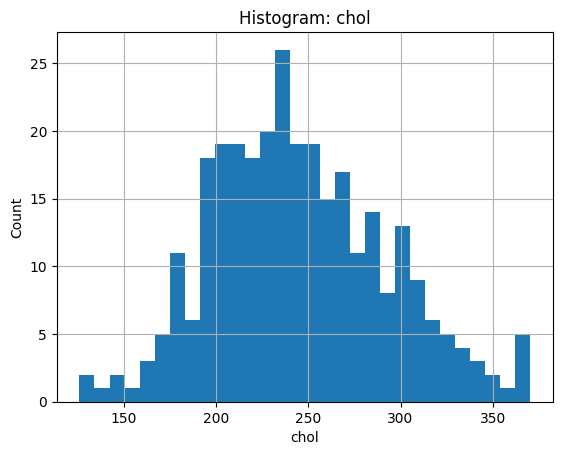

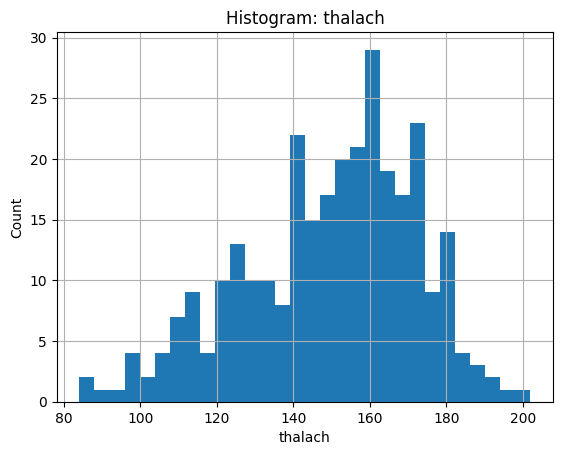

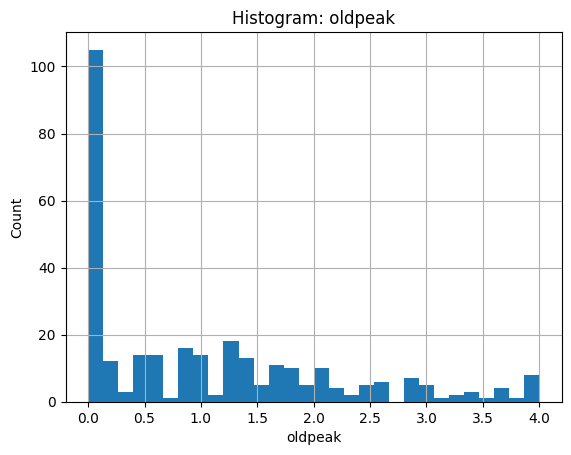

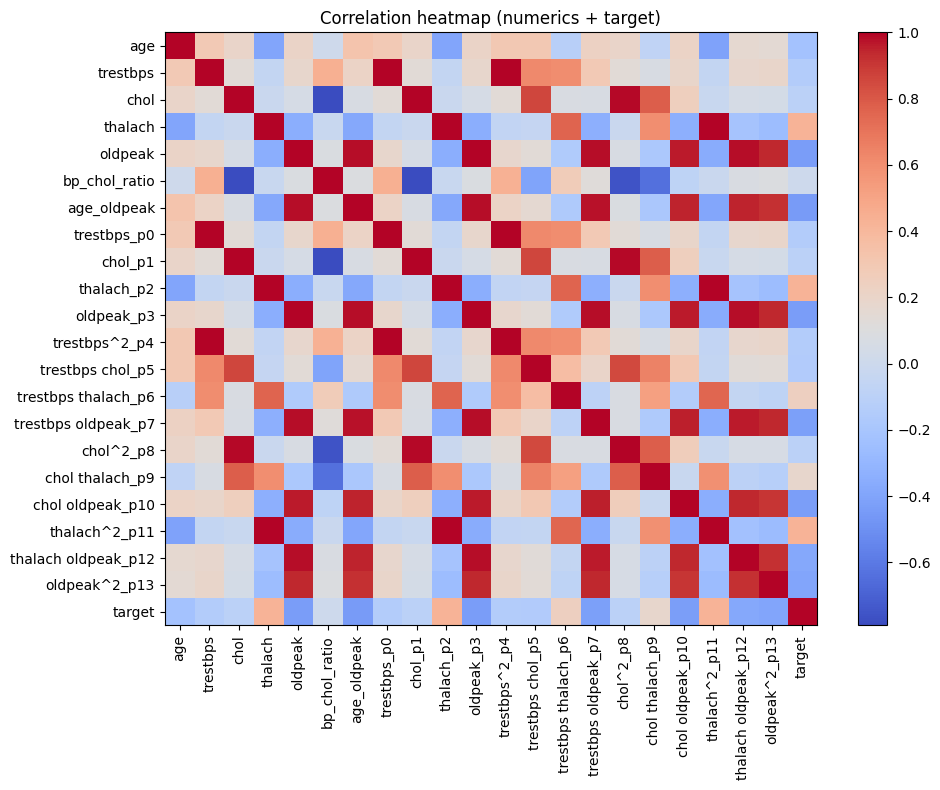

In [11]:
for col in ['age','trestbps','chol','thalach','oldpeak']:
    plt.figure()
    X_fe[col].hist(bins=30)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col); plt.ylabel("Count")
    plt.show()

corr = pd.concat([X_fe[num_cols_ext], y_base], axis=1).corr()
plt.figure(figsize=(10,8))
plt.imshow(corr, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation heatmap (numerics + target)")
plt.tight_layout()
plt.show()


# Train/test split and preprocessing pipelines

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_fe, y_base, test_size=0.2, stratify=y_base, random_state=42
)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols_ext),
        ("cat", categorical_transformer, cat_cols_ext)
    ]
)


# Baseline supervised models

LogReg Accuracy: 0.8524590163934426
LogReg F1: 0.8695652173913043
LogReg ROC-AUC: 0.9004329004329005


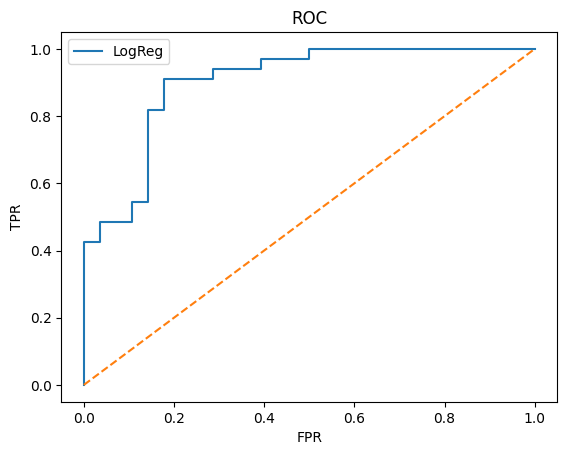

In [13]:
logreg_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=1000, n_jobs=None))
])

logreg_clf.fit(X_train, y_train)
pred_lr = logreg_clf.predict(X_test)
proba_lr = logreg_clf.predict_proba(X_test)[:,1]

print("LogReg Accuracy:", accuracy_score(y_test, pred_lr))
print("LogReg F1:", f1_score(y_test, pred_lr))
print("LogReg ROC-AUC:", roc_auc_score(y_test, proba_lr))

# ROC curve
fpr, tpr, _ = roc_curve(y_test, proba_lr)
plt.figure()
plt.plot(fpr, tpr, label="LogReg")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC")
plt.legend(); plt.show()


# Support Vector Machine

In [14]:
svc_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("svc", SVC(kernel="rbf", probability=True, random_state=42))
])
svc_clf.fit(X_train, y_train)
pred_svc = svc_clf.predict(X_test)
proba_svc = svc_clf.predict_proba(X_test)[:,1]
print("SVC Accuracy:", accuracy_score(y_test, pred_svc))
print("SVC F1:", f1_score(y_test, pred_svc))
print("SVC ROC-AUC:", roc_auc_score(y_test, proba_svc))


SVC Accuracy: 0.7868852459016393
SVC F1: 0.8059701492537313
SVC ROC-AUC: 0.8690476190476191


# Random Forest

In [15]:
rf_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("rf", RandomForestClassifier(n_estimators=300, random_state=42))
])
rf_clf.fit(X_train, y_train)
pred_rf = rf_clf.predict(X_test)
proba_rf = rf_clf.predict_proba(X_test)[:,1]
print("RF Accuracy:", accuracy_score(y_test, pred_rf))
print("RF F1:", f1_score(y_test, pred_rf))
print("RF ROC-AUC:", roc_auc_score(y_test, proba_rf))


RF Accuracy: 0.7704918032786885
RF F1: 0.8
RF ROC-AUC: 0.8701298701298702


Gaussian Naive Bayes (classification)

In [16]:
gnb_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("gnb", GaussianNB())
])
gnb_clf.fit(X_train, y_train)
pred_gnb = gnb_clf.predict(X_test)
proba_gnb = gnb_clf.predict_proba(X_test)[:,1]
print("GNB Accuracy:", accuracy_score(y_test, pred_gnb))
print("GNB F1:", f1_score(y_test, pred_gnb))
print("GNB ROC-AUC:", roc_auc_score(y_test, proba_gnb))


GNB Accuracy: 0.7540983606557377
GNB F1: 0.7619047619047619
GNB ROC-AUC: 0.8398268398268398


Linear Regression

In [17]:
linreg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("lr", LinearRegression())
])
linreg.fit(X_train, y_train)
pred_lr_cont = linreg.predict(X_test)
pred_lr_bin = (pred_lr_cont >= 0.5).astype(int)
print("LinearReg (threshold 0.5) Accuracy:", accuracy_score(y_test, pred_lr_bin))
print("LinearReg ROC-AUC:", roc_auc_score(y_test, pred_lr_cont))


LinearReg (threshold 0.5) Accuracy: 0.8032786885245902
LinearReg ROC-AUC: 0.8787878787878789


# PCA (exploration + logistic on PCs)

PCA n_components_ (95% var): 13


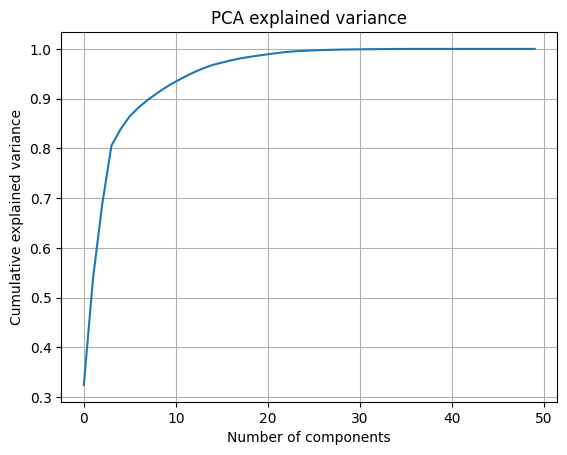

LogReg on PCA - ROC-AUC: 0.8971861471861472


In [18]:
pca_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("pca", PCA(n_components=0.95, svd_solver="full"))  # keep 95% variance
])

X_train_pcs = pca_pipeline.fit_transform(X_train, y_train)
X_test_pcs = pca_pipeline.transform(X_test)

print("PCA n_components_ (95% var):", pca_pipeline.named_steps['pca'].n_components_)

#variance plot
pca_full = Pipeline(steps=[("preprocess", preprocess), ("pca", PCA())])
pca_full.fit(X_train)
pca_obj = pca_full.named_steps['pca']

plt.figure()
plt.plot(np.cumsum(pca_obj.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA explained variance")
plt.grid(True)
plt.show()

# Logistic on PCA features
logreg_on_pca = LogisticRegression(max_iter=1000)
logreg_on_pca.fit(X_train_pcs, y_train)
pca_probs = logreg_on_pca.predict_proba(X_test_pcs)[:,1]
pca_preds = (pca_probs >= 0.5).astype(int)
print("LogReg on PCA - ROC-AUC:", roc_auc_score(y_test, pca_probs))


# Hyperparameter tuning (Grid/RandomizedSearch)

In [19]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# logistic Regression (C)
param_lr = {"clf__C": [0.01, 0.1, 1, 3, 10], "clf__penalty": ["l2"], "clf__solver": ["lbfgs","liblinear"]}
pipe_lr = Pipeline([("preprocess", preprocess), ("clf", LogisticRegression(max_iter=2000))])
gs_lr = GridSearchCV(pipe_lr, param_lr, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=1)
gs_lr.fit(X_train, y_train)
print("Best LR params:", gs_lr.best_params_, "AUC:", gs_lr.best_score_)

# svc
param_svc = {"svc__C": [0.1, 1, 5, 10], "svc__gamma": ["scale", 0.1, 0.01]}
pipe_svc = Pipeline([("preprocess", preprocess), ("svc", SVC(probability=True, random_state=42))])
gs_svc = GridSearchCV(pipe_svc, param_svc, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=1)
gs_svc.fit(X_train, y_train)
print("Best SVC params:", gs_svc.best_params_, "AUC:", gs_svc.best_score_)

# random Forest
param_rf = {
    "rf__n_estimators": [200, 400, 600],
    "rf__max_depth": [None, 4, 6, 8, 12],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4]
}
pipe_rf = Pipeline([("preprocess", preprocess), ("rf", RandomForestClassifier(random_state=42))])
gs_rf = RandomizedSearchCV(pipe_rf, param_rf, cv=cv, scoring="roc_auc", n_jobs=-1, n_iter=20, verbose=1, random_state=42)
gs_rf.fit(X_train, y_train)
print("Best RF params:", gs_rf.best_params_, "AUC:", gs_rf.best_score_)

# evaluate tuned best on test
for name, m in [("LR", gs_lr.best_estimator_), ("SVC", gs_svc.best_estimator_), ("RF", gs_rf.best_estimator_)]:
    proba = m.predict_proba(X_test)[:,1]
    pred = (proba>=0.5).astype(int)
    print(f"\n{name} Test AUC:", roc_auc_score(y_test, proba))
    print(f"{name} Test F1:", f1_score(y_test, pred))
    print(classification_report(y_test, pred))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best LR params: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'} AUC: 0.9027324527324527
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best SVC params: {'svc__C': 5, 'svc__gamma': 0.01} AUC: 0.8952214452214452
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF params: {'rf__n_estimators': 400, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 4, 'rf__max_depth': None} AUC: 0.8790986790986791

LR Test AUC: 0.9036796536796537
LR Test F1: 0.8405797101449275
              precision    recall  f1-score   support

           0       0.84      0.75      0.79        28
           1       0.81      0.88      0.84        33

    accuracy                           0.82        61
   macro avg       0.82      0.81      0.82        61
weighted avg       0.82      0.82      0.82        61


SVC Test AUC: 0.9036796536796536
SVC Test F1: 0.8529411764705882
              precision    recall  f1-

KMeans & GMM

In [20]:
#numeric matrix
prep_only = preprocess.fit(X_train, y_train)
X_train_proc = prep_only.transform(X_train)
X_test_proc = prep_only.transform(X_test)

# kmeans
sil_scores = {}
for k in range(2, 7):
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X_train_proc)
    sil = silhouette_score(X_train_proc, labels)
    sil_scores[k] = sil
print("KMeans silhouette scores:", sil_scores)

best_k = max(sil_scores, key=sil_scores.get)
km_best = KMeans(n_clusters=best_k, n_init=50, random_state=42).fit(X_train_proc)
train_labels = km_best.predict(X_train_proc)
print("Adjusted Rand Index vs target (train):", adjusted_rand_score(y_train, train_labels))

# Gaussian mixture models
bics = {}
for k in range(2, 7):
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42, n_init=5)
    gmm.fit(X_train_proc)
    bics[k] = gmm.bic(X_train_proc)
print("GMM BIC by components:", bics)
best_k_gmm = min(bics, key=bics.get)
gmm_best = GaussianMixture(n_components=best_k_gmm, covariance_type='full', random_state=42, n_init=10).fit(X_train_proc)
gmm_labels = gmm_best.predict(X_train_proc)
print("GMM Adjusted Rand Index (train) vs target:", adjusted_rand_score(y_train, gmm_labels))


KMeans silhouette scores: {2: np.float64(0.2414347840740817), 3: np.float64(0.16562605323372606), 4: np.float64(0.1726506231803944), 5: np.float64(0.17297110551189768), 6: np.float64(0.1433344167659056)}
Adjusted Rand Index vs target (train): 0.2162376624196873
GMM BIC by components: {2: np.float64(-27563.445508173812), 3: np.float64(-26295.00847993371), 4: np.float64(-21055.292387654663), 5: np.float64(-16572.47180624972), 6: np.float64(-13658.277544233046)}
GMM Adjusted Rand Index (train) vs target: 0.22435223345999747


Feature selection

#Mutual Information on fully preprocessed features
# Need feature names after OHE:

In [21]:
ohe = prep_only.named_transformers_['cat'].named_steps['ohe']
cat_feature_names = list(ohe.get_feature_names_out(cat_cols_ext))
num_feature_names = num_cols_ext
all_feat_names = num_feature_names + cat_feature_names

X_train_df = pd.DataFrame(X_train_proc.toarray() if hasattr(X_train_proc, "toarray") else X_train_proc,
                          columns=all_feat_names, index=X_train.index)

mi = mutual_info_classif(X_train_df, y_train, random_state=42)
mi_series = pd.Series(mi, index=all_feat_names).sort_values(ascending=False)
print("Top 15 features by Mutual Information:")
display(mi_series.head(15))

#RFECV with Logistic Regression
from sklearn.linear_model import LogisticRegression
estimator = LogisticRegression(max_iter=2000, solver="liblinear")
rfecv_pipe = Pipeline([
    ("preprocess", preprocess),
    ("rfecv", RFECV(estimator=estimator, step=1, cv=StratifiedKFold(5), scoring="roc_auc", n_jobs=-1))
])
rfecv_pipe.fit(X_train, y_train)
print("RFECV n_features_:", rfecv_pipe.named_steps['rfecv'].n_features_)

#L1-based selection
l1_pipe = Pipeline([
    ("preprocess", preprocess),
    ("clf", LogisticRegression(penalty="l1", solver="liblinear", C=0.5, max_iter=2000))
])
l1_pipe.fit(X_train, y_train)
proba_l1 = l1_pipe.predict_proba(X_test)[:,1]
print("L1-LogReg Test AUC:", roc_auc_score(y_test, proba_l1))


Top 15 features by Mutual Information:


,0
thal_2,0.178906
cp_0,0.147051
oldpeak,0.128802
chol oldpeak_p10,0.115151
ca_0,0.109827
thal_3,0.103401
oldpeak_p3,0.101606
chol_p1,0.095382
age_oldpeak,0.094043
thalach oldpeak_p12,0.093420


RFECV n_features_: 20
L1-LogReg Test AUC: 0.9058441558441559


Class balancing (SMOTE inside pipeline)

In [22]:
smote_pipe = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(max_iter=2000))
])

#CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []
for tr_idx, val_idx in cv.split(X_train, y_train):
    smote_pipe.fit(X_train.iloc[tr_idx], y_train.iloc[tr_idx])
    proba = smote_pipe.predict_proba(X_train.iloc[val_idx])[:,1]
    scores.append(roc_auc_score(y_train.iloc[val_idx], proba))
print("SMOTE+LogReg mean AUC (CV on train):", np.mean(scores))

smote_pipe.fit(X_train, y_train)
proba_sm = smote_pipe.predict_proba(X_test)[:,1]
pred_sm = (proba_sm>=0.5).astype(int)
print("SMOTE+LogReg Test AUC:", roc_auc_score(y_test, proba_sm))
print(classification_report(y_test, pred_sm))


SMOTE+LogReg mean AUC (CV on train): 0.8984071484071485
SMOTE+LogReg Test AUC: 0.8928571428571429
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        28
           1       0.85      0.85      0.85        33

    accuracy                           0.84        61
   macro avg       0.83      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



Save best model

In [24]:
#PCA visualization
pca_2 = PCA(n_components=2)
X_vis = pca_2.fit_transform(np.vstack([X_train_proc_dense.toarray() if hasattr(X_train_proc_dense, "toarray") else X_train_proc_dense]))
plt.figure()
plt.scatter(X_vis[:,0], X_vis[:,1], c=y_train, alpha=0.7)
plt.title("PCA(2D) colored by target (train)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


NameError: name 'X_train_proc_dense' is not defined

Dask demo (read, compute, describe)

In [25]:
import dask.dataframe as dd

ddf = dd.read_csv(csv_path, assume_missing=True)
print(ddf.head())

#miss val and describe
missing_dask = ddf.isna().sum().compute()
print("\nDask missing values:")
print(missing_dask)

desc_dask = ddf.describe().compute()
print("\nDask describe:")
print(desc_dask)


    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  3.0     145.0  233.0  1.0      0.0    150.0    0.0      2.3   
1  37.0  1.0  2.0     130.0  250.0  0.0      1.0    187.0    0.0      3.5   
2  41.0  0.0  1.0     130.0  204.0  0.0      0.0    172.0    0.0      1.4   
3  56.0  1.0  1.0     120.0  236.0  0.0      1.0    178.0    0.0      0.8   
4  57.0  0.0  0.0     120.0  354.0  0.0      1.0    163.0    1.0      0.6   

   slope   ca  thal  target  
0    0.0  0.0   1.0     1.0  
1    0.0  0.0   2.0     1.0  
2    2.0  0.0   2.0     1.0  
3    2.0  0.0   2.0     1.0  
4    2.0  0.0   2.0     1.0  

Dask missing values:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Dask describe:
              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000

Streamlit app

In [26]:
%%writefile app.py
import joblib
import numpy as np
import pandas as pd
import streamlit as st

st.set_page_config(page_title="Heart Risk Demo", page_icon="❤️", layout="centered")
st.title("Heart Disease Prediction (Demo)")

# load saved model
model = joblib.load("best_heart_model.joblib")

# input
age = st.number_input("age", min_value=18, max_value=120, value=54)
sex = st.selectbox("sex (1=male,0=female)", options=[0,1], index=1)
cp = st.selectbox("cp (0-3)", options=[0,1,2,3], index=0)
trestbps = st.number_input("trestbps", min_value=80, max_value=220, value=130)
chol = st.number_input("chol", min_value=80, max_value=700, value=246)
fbs = st.selectbox("fbs (fasting blood sugar>120 mg/dl)", options=[0,1], index=0)
restecg = st.selectbox("restecg (0-2)", options=[0,1,2], index=1)
thalach = st.number_input("thalach", min_value=60, max_value=250, value=150)
exang = st.selectbox("exang (exercise induced angina)", options=[0,1], index=0)
oldpeak = st.number_input("oldpeak (ST depression)", min_value=0.0, max_value=10.0, value=1.0, step=0.1)
slope = st.selectbox("slope (0-2)", options=[0,1,2], index=2)
ca = st.selectbox("ca (0-4)", options=[0,1,2,3,4], index=0)
thal = st.selectbox("thal (0=unknown/1=normal/2=fixed/3=reversible) *dataset-coded*", options=[0,1,2,3], index=3)

if st.button("Predict"):

    input_df = pd.DataFrame([{
        'age': age, 'sex': sex, 'cp': cp, 'trestbps': trestbps, 'chol': chol,
        'fbs': fbs, 'restecg': restecg, 'thalach': thalach, 'exang': exang,
        'oldpeak': oldpeak, 'slope': slope, 'ca': ca, 'thal': thal
    }])
    # feature engineering
    input_df['bp_chol_ratio'] = input_df['trestbps'] / (input_df['chol'] + 1e-6)
    input_df['age_oldpeak'] = input_df['age'] * input_df['oldpeak']
    input_df['age_bin'] = pd.cut(input_df['age'], bins=[0,40,50,60,120], labels=[0,1,2,3], include_lowest=True)

    # poly features
    from sklearn.preprocessing import PolynomialFeatures
    poly_feats = ['trestbps','chol','thalach','oldpeak']
    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_mat = poly.fit_transform(input_df[poly_feats])
    poly_cols = [f"{v}_p{ix}" for ix, v in enumerate(poly.get_feature_names_out(poly_feats))]
    poly_df = pd.DataFrame(poly_mat, columns=poly_cols, index=input_df.index)
    input_df = pd.concat([input_df, poly_df], axis=1)

    # predict
    prob = model.predict_proba(input_df)[0,1]
    pred = int(prob >= 0.5)
    st.subheader(f"Probability of heart disease: {prob:.3f}")
    st.subheader(f"Predicted class: {pred} (1 = Disease, 0 = No)")
    if prob >= 0.5:
        st.warning("Model leans toward risk. This is not medical advice.")
    else:
        st.success("Model leans toward no risk. This is not medical advice.")


Writing app.py


In [28]:
!pip install streamlit pyngrok


In [31]:
!ngrok authtoken 2xMPKIlV0JGFCxpcpP7KY40rxQc_4XX3eJQTxC2BrdGDNL4KZ


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [32]:
from pyngrok import ngrok
import os

os.system("streamlit run app.py &")
public_url = ngrok.connect(port='8501')
print(public_url)


PyngrokNgrokHTTPError: ngrok client exception, API returned 400: {"error_code":102,"status_code":400,"msg":"invalid tunnel configuration","details":{"err":"yaml: unmarshal errors:\n  line 1: field port not found in type config.HTTPv2Tunnel"}}


In [27]:
# This will start Streamlit, but in Colab you'll need a tunnel to view it.
# Easiest is to use 'localtunnel' or 'ngrok'. Example (uncomment to try with localtunnel):
# !npm install -g localtunnel
# import subprocess, time
# p = subprocess.Popen(["streamlit", "run", "app.py", "--server.port", "8501"])
# time.sleep(5)
# !lt --port 8501 --subdomain heartdemo-$(python - <<<'import random;print(random.randint(1000,9999))')
# Stop with: p.terminate()
pass


In [33]:
!npm install -g localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹
added 22 packages in 2s
⠹
⠹3 packages are looking for funding
⠹  run `npm fund` for details
⠹

In [ ]:
import subprocess, time
p = subprocess.Popen(["streamlit", "run", "app.py", "--server.port", "8501"])
time.sleep(5)
!lt --port 8501 --subdomain heartdemo-$(python - <<<'import random;print(random.randint(1000,9999))')
p.terminate()
pass

your url is: https://heartdemo-5244.loca.lt
